In [1]:
import logging
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import EarlyStopping

from pywt import wavedec, WaveletPacket, waverec

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import signal as signal_lib
import time
import random

In [2]:
def get_wavelet_coefs(input_data):
    girdi = np.array(input_data)
    level = int(np.log2(len(girdi)))
    coeff = wavedec(girdi, "haar", level=level)
    return np.round(np.concatenate(coeff), decimals=2)

In [3]:
def extract_features( data, dataset="dataset_1", test_set=""):
    
    train_operations = data[dataset]["train"+test_set]
    test_operations = data[dataset]["test"+test_set]

    train_data = np.zeros((len(train_operations), 80, 32), dtype=np.float64)
    train_target = np.zeros((len(train_operations), 10))

    test_data = np.zeros((len(test_operations), 80, 32), dtype=np.float64)
    test_target = np.zeros((len(test_operations), 10))
    
    for counter in range(len(train_operations)):
        signal = train_operations[counter]["supervised_signal"]
        
        signal_len = int((len(signal) - window_size) / offset + 1)
        

        for j in range(signal_len):
            data_window = np.array(signal[j * offset: j * offset + window_size])
            n = max(abs(data_window))
            if n > 1:
                data_window = list((data_window) / n)
            else:
                data_window = np.zeros(len(data_window))
            data_window=data_window*10
            w = get_wavelet_coefs(data_window)
            train_data[counter, j, :] = w[:32]            
        y = train_operations[counter]["label"]
        train_target[counter, y] = 1
    
    for counter in range(len(test_operations)):
        signal = test_operations[counter]["supervised_signal"]
        
        signal_len = int((len(signal) - window_size) / offset + 1)
        

        for j in range(signal_len):
            data_window = np.array(signal[j * offset: j * offset + window_size])
            n = max(abs(data_window))
            if n > 1:
                data_window = list((data_window) / n)
            else:
                data_window = np.zeros(len(data_window))
            data_window=data_window*10
            w = get_wavelet_coefs(data_window)
            test_data[counter, j, :] = w[:32]
            
        y = test_operations[counter]["label"]
        test_target[counter, y] = 1
        
        

         
    return train_data, train_target,  test_data, test_target


In [4]:
dataset = pickle.load(open("data/dataset_new.pkl", "rb"))
window_size = 128
offset = 64
sample_size = int((len(dataset["dataset_1"]["train"][0]["supervised_signal"])-offset)/offset)
print(sample_size)

79


In [5]:
dataset.keys()

dict_keys(['dataset_1', 'dataset_2', 'dataset_3', 'validation'])

5120 5120
signal 1 non zero samples 1916
signal 2 non zero samples 2427


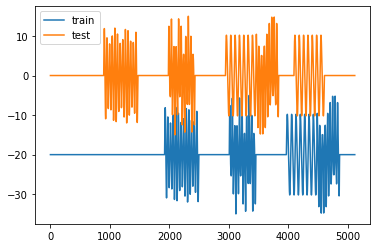

In [6]:
i=5

signal1 = dataset["dataset_1"]["test"][i]["supervised_signal"]
plt.plot(np.array(signal1)-20, label="train")
signal2 = dataset["dataset_1"]["test"][i]["unsupervised_signal"]
plt.plot(np.array(signal2), label="test")
plt.legend()
print(len(signal1), len(signal2))
count=0
for s in signal1:
    if s!=0:
        count+=1
print("signal 1 non zero samples", count)
count=0
for s in signal2:
    if s!=0:
        count+=1
print("signal 2 non zero samples", count)


# Dataset 1

In [7]:
train_data, train_target,  test_data, test_target = extract_features(dataset, "dataset_1")

In [8]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Conv1D, Flatten, Input
import tensorflow as tf
from tensorflow import keras

input_shape = [80, 32]
model = Sequential()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(4, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu')),
    tf.keras.layers.Conv1D(128, 8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=28),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

print("Compiling ...")

opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 80, 8)            264       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 80, 4)            36        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 80, 8)            40        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 80, 16)           144       
 tributed)                                                       
                                                                 
 conv1d (Conv1D)             (None, 73, 128)          

In [ ]:
print("Training ... ")
model.fit(train_data, train_target, validation_data=(train_data, train_target),batch_size=100, epochs=1000,  callbacks=[es], verbose=0)
loss, accuracy = model.evaluate(test_data, test_target)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Dataset 2

In [ ]:
for i in range(10):
    print("test ", i)
    train_data, train_target,  test_data, test_target = extract_features(dataset, "dataset_2", test_set =str(i))
    print(train_data.shape, train_target.shape,  test_data.shape, test_target.shape)
    input_shape = [80, 32]
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(4, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu')),
        tf.keras.layers.Conv1D(128, 8, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(32, 8, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=28),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    print("Compiling ...")

    opt = Adam()
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

    print("Training ... ")
    model.fit(train_data, train_target, validation_data=(train_data, train_target),batch_size=100, epochs=1000,  callbacks=[es], verbose=0)
    
    loss, accuracy = model.evaluate(test_data, test_target)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    
   


# Dataset 3

In [ ]:
train_data, train_target,  test_data, test_target = extract_features(dataset, "dataset_3")

In [ ]:
input_shape = [80, 32]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(4, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu')),
    tf.keras.layers.Conv1D(256, 8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, 8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=28),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

print("Compiling ...")

opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

print("Training ... ")
model.fit(train_data, train_target, validation_data=(train_data, train_target),batch_size=100, epochs=1000,  callbacks=[es], verbose=0)

loss, accuracy = model.evaluate(test_data, test_target)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)